In [163]:
import glob
import sys 

import numpy as np
import pandas as pd
import torch

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from IPython.display import display

sys.path.append("../src")
from evaluate import evalSingleEdits

In [220]:
class ModelComps:
    def __init__(self, model_name, base_name, archive=False):
        
        self.archive = archive
        self.model_name = model_name
        self.base_name = base_name
        self.ots_name = "OTS"
        self.models = {}
        self.modelStats = self.getModelParams()
        
        self.stats = {}
    
    
    def getModelParams(self):
        model_id = ".".join(self.model_name.split(".")[1:])
        return pd.Series(torch.load(f"../models/hypers.{model_id}")).to_frame().T
        

    def readData(self, model_name, kind='model'):
        if self.archive:
            eval_glob = glob.glob(f"./archive/*{model_name}")
        else:
            eval_glob = glob.glob(f"./*{model_name}")
        for evaluation in eval_glob:
            df = pd.read_csv(evaluation)
            eval_id = f"{kind}_{evaluation.split('.')[4].split('_')[0]}"
            self.models[eval_id] = df
    
    def runStats(self):
        if not self.models:
            self.readData(self.base_name, kind='base')
            self.readData(self.model_name)
            self.readData(self.ots_name, kind='ots')
            
        for name, model in self.models.items():  
            mean_new_ppl = model.new_ppl.mean() 
            mean_orig_ppl = model.orig_ppl.mean() 
            pct_ppl_dd = model.apply(lambda x: (x.new_ppl - x.orig_ppl)/x.orig_ppl, axis=1).mean()
            gross_ppl_dd = model.apply(lambda x: x.new_ppl - x.orig_ppl, axis=1).mean()
            success_by_logits = model.success.mean()
            
            try:
                success_by_probs = model.apply(lambda x: x.new_prob > x.old_prob, axis=1).mean()
            except AttributeError:
                success_by_probs = np.nan
                
            try:
                n_edit_steps = model.n_edit_steps.max()
            except:
                n_edit_steps = np.nan
            
            self.stats[name] = {
                "edit_steps":n_edit_steps,
                "mean_new_ppl":mean_new_ppl,
                "mean_orig_ppl":mean_orig_ppl,
                "pct_ppl_dd":pct_ppl_dd,
                "gross_ppl_dd":gross_ppl_dd,
                "success_by_logits":success_by_logits,
                "success_by_probs":success_by_probs,
            }
    
    @property
    def statDf(self):
        stats_df = (
            pd.DataFrame(self.stats).T
            .reset_index()
            .rename(columns={'index':'model'})
            .sort_values(["model", "edit_steps"], ascending=False)
        )
        
        return stats_df
    
    def summary(self):
        if not self.stats:
            self.runStats()
        print("Model Parameters:")
        display(self.modelStats)
        
        print("Success Metrics")
        stats_df = (
            pd.DataFrame(self.stats).T
            .reset_index()
            .rename(columns={'index':'model'})
            .sort_values(["model", "edit_steps"], ascending=False)
        )
        
        display(stats_df)
        
    
    def runEvaluation(self, n_edit_steps=[1], ots=False, baseline=False):
        
        dataloader = retrieveDataloader(
            tokenizer, bs=1, dataset='valid', max_obs=500
        )

        for nes in n_edit_steps:
            model_path = f"../models/{self.model_name}"
            model, tokenizer = loadTrainedModel(model_path)
            _, _ = evalSingleEdits(
                model, 
                dataloader, 
                model_path, 
                int(nes)
                )
            if baseline:
                base_path = f"../models/finetune/{self.baseline}"
                model_baseline, _ = loadTrainedModel(base_path)
                _, _ = evalSingleEdits(
                    model_baseline, 
                    dataloader, 
                    base_path, 
                    int(nes)
                    )
            if ots:
                model_ots, _ = loadOTSModel()
                _, _ = evalSingleEdits(
                    model_ots, 
                    dataloader, 
                    "OTS", 
                    int(nes)
                    )
                
    def plotter(self):
        print("Plotting Logits")
        for name, model in self.models.items():
            print(name)
            try:
                plt.hist(model.orig_logits, alpha=0.3, label="orig")
                plt.hist(model.new_logits, alpha=0.3, label="new")
                plt.legend()
                plt.show()
            except:
                continue
       
        print("Plotting % Logit Diffs")
        for name, model in self.models.items():
            try:
                plt.hist((model.orig_logits - model.new_logits) / model.orig_logits, alpha=0.3, label=name)
            except:
                continue
        plt.legend()
        plt.show()



# model_epoch0_ts10000.20210314.16.03.1615740151
## cedit=1, cloc=10, 10k steps
Notes: Model run morning of 3/14, showed best performance to date.

In [221]:
comps = ModelComps(
    model_name="model_epoch0_ts10000.20210314.16.03.1615740151",
    base_name="gpt2_epoch0_ts10000.20210310.18.03.1615401990",
    archive=True
)

comps.summary()

Model Parameters:


,inner_lr,outer_lr,n_edit_steps,cedit,cloc
0,0.001,0.00001,1.0,1.0,10.0


Success Metrics


,model,edit_steps,mean_new_ppl,mean_orig_ppl,pct_ppl_dd,gross_ppl_dd,success_by_logits,success_by_probs
5,ots_1615751556,3.0,91.285610,90.703072,0.006422,0.582538,0.74,0.88
2,model_1615752938,1.0,77.669995,77.696777,-0.000345,-0.026782,0.86,0.92
3,model_1615750890,3.0,83.744809,77.696777,0.077841,6.048032,0.90,0.94
4,model_1615750412,5.0,95.364924,77.696777,0.227399,17.668147,0.86,0.88
0,base_1615752056,3.0,49.590736,49.353867,0.004799,0.236870,0.78,0.88
1,base_1615404464,NaN,53.371377,50.168995,0.063832,3.202382,0.66,NaN


Plotting Logits
base_1615752056


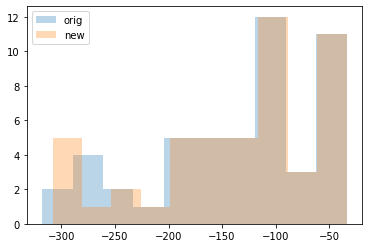

base_1615404464
model_1615752938


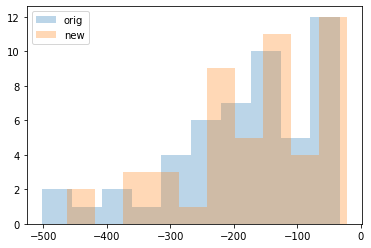

model_1615750890


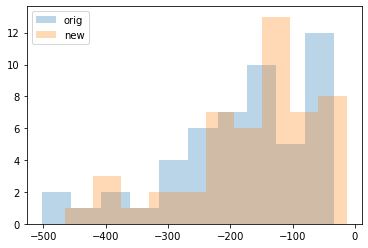

model_1615750412


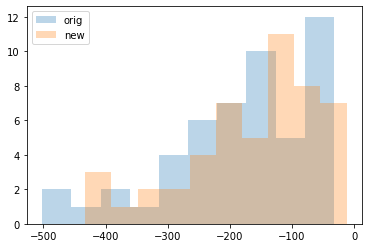

ots_1615751556


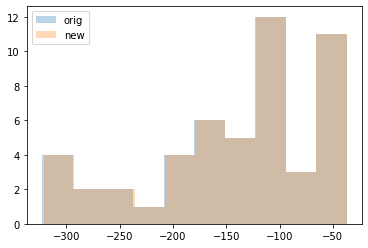

Plotting % Logit Diffs


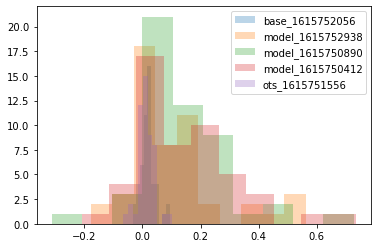

In [222]:
comps.plotter()

# model_epoch0_ts6000.20210314.16.03.1615740151
## cedit=1, cloc=10, 6k steps
Notes: same model, checking to see if evaluating an earlier checkpoint might be better. Tried with a number of checkpoints, generally worse

In [172]:
comps = ModelComps(
    model_name="model_epoch0_ts6000.20210314.16.03.1615740151",
    base_name="gpt2_epoch0_ts10000.20210310.18.03.1615401990"
)

comps.summary()

Model Parameters:


,inner_lr,outer_lr,n_edit_steps,cedit,cloc
0,0.001,0.00001,1.0,1.0,10.0


Success Metrics


,model,edit_steps,mean_new_ppl,mean_orig_ppl,pct_ppl_dd,gross_ppl_dd,success_by_logits,success_by_probs
3,ots_1615751556,3.0,91.285610,90.703072,0.006422,0.582538,0.74,0.88
2,model_1615754734,3.0,97.099067,85.292526,0.138424,11.806540,0.86,0.88
0,base_1615752056,3.0,49.590736,49.353867,0.004799,0.236870,0.78,0.88
1,base_1615404464,NaN,53.371377,50.168995,0.063832,3.202382,0.66,NaN


# model_epoch0_ts10000.20210312.21.03.1615586239
## cedit=1, cloc=1, 10k steps
Notes: Model run Friday 3/12, first try with editing loss calculated just on the modified tokens. Has worse statistics

In [171]:
comps = ModelComps(
    model_name="model_epoch0_ts10000.20210312.21.03.1615586239",
    base_name="gpt2_epoch0_ts10000.20210310.18.03.1615401990",
    archive=True
)

comps.summary()

Model Parameters:


,inner_lr,outer_lr,n_edit_steps,cedit,cloc
0,0.001,0.00001,1.0,1.0,1.0


Success Metrics


,model,edit_steps,mean_new_ppl,mean_orig_ppl,pct_ppl_dd,gross_ppl_dd,success_by_logits,success_by_probs
7,ots_1615751556,3.0,91.285610,90.703072,0.006422,0.582538,0.74,0.88
4,model_1615756602,5.0,194.801235,94.858231,1.053604,99.943004,0.92,0.92
6,model_1615756166,1.0,145.216881,94.858231,0.530883,50.358650,0.88,0.94
5,model_1615755665,3.0,212.287687,94.858231,1.237947,117.429456,0.86,0.92
2,model_1615593547,5.0,227.094710,94.858231,1.394043,132.236479,0.14,NaN
3,model_1615593107,NaN,159.165088,94.858231,0.677926,64.306857,0.18,NaN
0,base_1615752056,3.0,49.590736,49.353867,0.004799,0.236870,0.78,0.88
1,base_1615404464,NaN,53.371377,50.168995,0.063832,3.202382,0.66,NaN
